In [ ]:
!pip install deepface

In [ ]:
!pip install tensorflow-io
!pip install elasticsearch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import packages

In [ ]:
from deepface import DeepFace
from deepface.basemodels import Facenet
from deepface.commons import functions

import matplotlib.pyplot as plt
import numpy as np

import random
import matplotlib.image as mpimg
import os
import pickle

import time
from elasticsearch import Elasticsearch
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd

import json
import pandas as pd
import requests

import re

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


Elastic Search

In [ ]:
%%bash

wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
tar -xzf elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
sudo chown -R daemon:daemon elasticsearch-7.9.2/
shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512 

elasticsearch-oss-7.9.2-linux-x86_64.tar.gz: OK


In [ ]:
%%bash --bg

sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch

Starting job # 0 in a separate thread.


In [ ]:
# Sleep for few seconds to let the instance start.
time.sleep(20)

In [ ]:
%%bash

ps -ef | grep elasticsearch

root         200     198  0 02:36 ?        00:00:00 sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch
daemon       201     200 99 02:36 ?        00:00:25 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -XX:+ShowCodeDetailsInExceptionMessages -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=SPI,COMPAT -Xms1g -Xmx1g -XX:+UseG1GC -XX:G1ReservePercent=25 -XX:InitiatingHeapOccupancyPercent=30 -Djava.io.tmpdir=/tmp/elasticsearch-4999863749049681458 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:filecou

In [ ]:
%%bash

curl -sX GET "localhost:9200/"

{
  "name" : "1063b817dbca",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "f1HOhyLBRvyU0u7kYHN1nA",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "oss",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


Create "elastic" index

In [ ]:
%%bash

curl -sX PUT 'localhost:9200/elastic' \
  -H 'Content-Type: application/json' \

{"acknowledged":true,"shards_acknowledged":true,"index":"elastic"}

In [ ]:
def insertDataframeIntoElastic(dataFrame,index='elastic', typ = 'face', server = 'http://localhost:9200', chunk_size = 2000):
  headers = {'content-type': 'application/x-ndjson', 'Accept-Charset': 'UTF-8'}
  records = dataFrame.to_dict(orient='records')
  actions = ["""{ "index" : { "_index" : "%s", "_type" : "%s"} }\n""" % (index, typ) +json.dumps(records[j]) for j in range(len(records))]
  i=0
  while i<len(actions):
    serverAPI = server + '/_bulk' 
    data='\n'.join(actions[i:min([i+chunk_size,len(actions)])])
    data = data + '\n'
    r = requests.post(serverAPI, data = data, headers=headers)
    print(r.content)
    i = i+chunk_size

Transform model features to dataframe

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                filepath = os.path.join(root, filename)
                if os.path.exists(filepath):
                  file_list.append(filepath)
                else:
                  print(filepath)
    return file_list

In [ ]:
list_file = get_file_list('drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/deepfunneled')
root='drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/deepfunneled/lfw-deepfunneled'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]

In [ ]:
list_file = sorted(list_file)
dirlist = sorted(dirlist)

In [ ]:
model = Facenet.loadModel()
input_shape = functions.find_input_shape(model)

In [ ]:
df = pd.DataFrame(columns = ['Path', 'Representations'])
counter = 1000
for i in range(len(list_file)):
  if(i == counter):
    counter += 1000
    print("Gone through the first "+str(i)+"th faces, which is "+str(round(i/len(list_file),2))+"% of the data.")  
  try:
    normalized = functions.normalize_input(list_file[i])
    preprocessed = functions.preprocess_face(normalized, input_shape)
    represenation = model.predict(preprocessed)[0,:]
    df = df.append({'Path' : list_file[i], 'Representations' : represenation}, ignore_index = True)
  except:
    continue

Gone through the first 1000th faces, which is 0.08% of the data.
Gone through the first 2000th faces, which is 0.15% of the data.
Gone through the first 3000th faces, which is 0.23% of the data.
Gone through the first 4000th faces, which is 0.3% of the data.
Gone through the first 5000th faces, which is 0.38% of the data.
Gone through the first 6000th faces, which is 0.45% of the data.
Gone through the first 7000th faces, which is 0.53% of the data.
Gone through the first 8000th faces, which is 0.6% of the data.
Gone through the first 9000th faces, which is 0.68% of the data.
Gone through the first 10000th faces, which is 0.76% of the data.
Gone through the first 11000th faces, which is 0.83% of the data.
Gone through the first 12000th faces, which is 0.91% of the data.
Gone through the first 13000th faces, which is 0.98% of the data.


In [ ]:
df.head()

,Path,Representations
0,drive/My Drive/nyu second semester/artificial ...,"[-0.61650825, -0.36295557, 0.29242897, -0.4140..."
1,drive/My Drive/nyu second semester/artificial ...,"[0.23787875, 0.42983374, -1.3669863, 1.167738,..."
2,drive/My Drive/nyu second semester/artificial ...,"[-1.9144613, 0.4721296, -2.3119712, -0.8226508..."
3,drive/My Drive/nyu second semester/artificial ...,"[-1.0064372, -0.3309246, -2.275216, 1.0204922,..."
4,drive/My Drive/nyu second semester/artificial ...,"[-0.6732321, -0.06661366, 0.96323204, -0.54453..."


Save the dataframe as csv for future use

In [ ]:
df.to_csv("drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/elastic_search.csv", index=False)

In [ ]:
data = pd.read_csv("drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/elastic_search.csv")

Insert data into elastic search

In [ ]:
insertDataframeIntoElastic(data)

b'{"took":2187,"errors":false,"items":[{"index":{"_index":"elastic","_type":"face","_id":"16nwJYABEwQiYtEWVbGa","_version":1,"result":"created","_shards":{"total":2,"successful":1,"failed":0},"_seq_no":0,"_primary_term":1,"status":201}},{"index":{"_index":"elastic","_type":"face","_id":"2KnwJYABEwQiYtEWVbGc","_version":1,"result":"created","_shards":{"total":2,"successful":1,"failed":0},"_seq_no":1,"_primary_term":1,"status":201}},{"index":{"_index":"elastic","_type":"face","_id":"2anwJYABEwQiYtEWVbGc","_version":1,"result":"created","_shards":{"total":2,"successful":1,"failed":0},"_seq_no":2,"_primary_term":1,"status":201}},{"index":{"_index":"elastic","_type":"face","_id":"2qnwJYABEwQiYtEWVbGc","_version":1,"result":"created","_shards":{"total":2,"successful":1,"failed":0},"_seq_no":3,"_primary_term":1,"status":201}},{"index":{"_index":"elastic","_type":"face","_id":"26nwJYABEwQiYtEWVbGc","_version":1,"result":"created","_shards":{"total":2,"successful":1,"failed":0},"_seq_no":4,"_pr

In [ ]:
ES_NODES = "http://localhost:9200"

In [ ]:
es_client = Elasticsearch(hosts = [ES_NODES])

In [ ]:
%%bash

curl -sX GET 'localhost:9200/elastic' \
  -H 'Content-Type: application/json' \

{"elastic":{"aliases":{},"mappings":{"properties":{"Path":{"type":"text","fields":{"keyword":{"type":"keyword","ignore_above":256}}},"Representations":{"type":"text","fields":{"keyword":{"type":"keyword","ignore_above":256}}}}},"settings":{"index":{"creation_date":"1649903866171","number_of_shards":"1","number_of_replicas":"1","uuid":"rOnyYurHQ6qwtomxO07xDw","version":{"created":"7090299"},"provided_name":"elastic"}}}}

In [ ]:
all_ds = tfio.experimental.elasticsearch.ElasticsearchIODataset(
        nodes=[ES_NODES],
        index="elastic",
        doc_type="face"
    )

Connection successful: http://localhost:9200/_cluster/health


Check if the elastic search correctly stored the data

In [ ]:
ds_iter = iter(all_ds)
features = next(ds_iter)

In [ ]:
{key: value.numpy() for key,value in features.items()}

{'Path': b'drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/deepfunneled/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg',
 'Representations': b'[-0.61650825 -0.36295557  0.29242897 -0.41401008 -1.1053311  -0.86891687\n  2.5047348   0.39545494  0.30764088  0.61971116  0.55411565  0.3919313\n -1.4945618  -0.39128658  0.25966012  0.53626806  0.9343486  -0.39702094\n -0.01719292 -0.6692217  -0.5073191   0.6856878  -0.33552083 -0.71637815\n  0.9912831   1.8073915   1.5660036  -1.07327     0.34042114 -1.2243798\n -0.5891173  -0.44377953 -0.849448    0.4172578   1.4516459   0.73538345\n  0.48992002 -0.36195657  1.2513399  -1.6263342  -2.0088851   0.23701203\n -0.5153663   1.0952646   1.0368003   0.77579683 -0.33300877 -1.4995501\n -0.77283525  0.53761137  0.00913101 -0.41364688 -1.2308545   0.2979755\n -1.1746774   0.63819045  0.76215976  1.9639215   0.5611533  -1.1419584\n -0.4930219  -0.39216918 -0.2746658  -1.6793048   2.193523    1.2074515\n -0.46152085 -0.3542754

In [ ]:
features.get("Path").numpy()

b'drive/My Drive/nyu second semester/artificial intelligence/ai_project/Cody/LFW/deepfunneled/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg'

In [ ]:
features.get("Representations").numpy()

b'[-0.61650825 -0.36295557  0.29242897 -0.41401008 -1.1053311  -0.86891687\n  2.5047348   0.39545494  0.30764088  0.61971116  0.55411565  0.3919313\n -1.4945618  -0.39128658  0.25966012  0.53626806  0.9343486  -0.39702094\n -0.01719292 -0.6692217  -0.5073191   0.6856878  -0.33552083 -0.71637815\n  0.9912831   1.8073915   1.5660036  -1.07327     0.34042114 -1.2243798\n -0.5891173  -0.44377953 -0.849448    0.4172578   1.4516459   0.73538345\n  0.48992002 -0.36195657  1.2513399  -1.6263342  -2.0088851   0.23701203\n -0.5153663   1.0952646   1.0368003   0.77579683 -0.33300877 -1.4995501\n -0.77283525  0.53761137  0.00913101 -0.41364688 -1.2308545   0.2979755\n -1.1746774   0.63819045  0.76215976  1.9639215   0.5611533  -1.1419584\n -0.4930219  -0.39216918 -0.2746658  -1.6793048   2.193523    1.2074515\n -0.46152085 -0.35427547 -2.0271964   1.65668     0.89349234  0.5336317\n -0.3690687  -1.8014016   0.37152392 -1.4969457   0.20634979 -0.56751525\n -0.6711243   1.8175997  -1.5144618   0.551

Use facenet model to calculate Euclidean distance for different face (with elastic search results)

In [ ]:
records = data.to_dict(orient='records')

In [ ]:
def convert_str(string):
  convert = []
  string = string[1:-1].split()
  for i in range(len(string)):
    convert.append(float(string[i]))
  return convert

Euclidean distance:  18.541240153689717


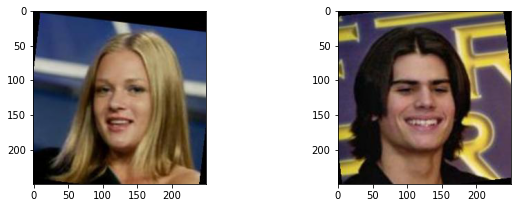

In [ ]:
img1_representation = convert_str(records[0]['Representations'])
img2_representation = convert_str(records[1]['Representations'])

distance_vector = np.square(np.array(img1_representation) - np.array(img2_representation))

distance = np.sqrt(distance_vector.sum())
print("Euclidean distance: ",distance)

fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2,2,1)

img1 = mpimg.imread(records[0]['Path'])
plt.imshow(img1)

ax3 = fig.add_subplot(2,2,2)
img2 = mpimg.imread(records[1]['Path'])
plt.imshow(img2)


Use facenet model to calculate Euclidean distance for same face (with elastic search results)

Euclidean distance:  7.574692652696725


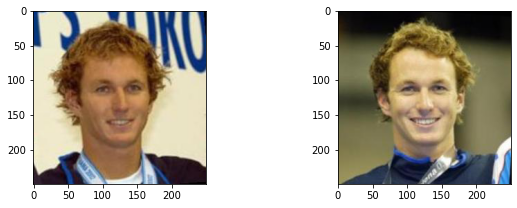

In [ ]:
img1_representation = convert_str(records[6]['Representations'])
img2_representation = convert_str(records[7]['Representations'])

distance_vector = np.square(np.array(img1_representation) - np.array(img2_representation))

distance = np.sqrt(distance_vector.sum())
print("Euclidean distance: ",distance)

fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2,2,1)

img1 = mpimg.imread(records[6]['Path'])
plt.imshow(img1)

ax3 = fig.add_subplot(2,2,2)
img2 = mpimg.imread(records[7]['Path'])
plt.imshow(img2)

From the above results, we can see that the it makes sense that the Euclidean distance for same face is smaller than different faces.